In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import cv2
from scipy.spatial import distance
from google.colab.patches import cv2_imshow
from PIL import Image
import csv
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cost at initial w and b (zeros): 0.694
dj_db at test w and b: -0.6929078014184397
dj_dw at test w and b: [-142562.0782065798, -270.8326689716313, -8.103037234042553, -3.3869468085106367]
Iteration    0: Cost     0.19   
Iteration  100: Cost     0.18   
Iteration  200: Cost     0.18   
Iteration  300: Cost     0.17   
Iteration  400: Cost     0.16   
Iteration  500: Cost     0.16   
Iteration  600: Cost     0.15   
Iteration  700: Cost     0.14   
Iteration  800: Cost     0.14   
Iteration  900: Cost     0.13   
Iteration  999: Cost     0.13   
The number of 1s in the num_stars array is: 1138
The number of 1s in the predicted array is: 1346


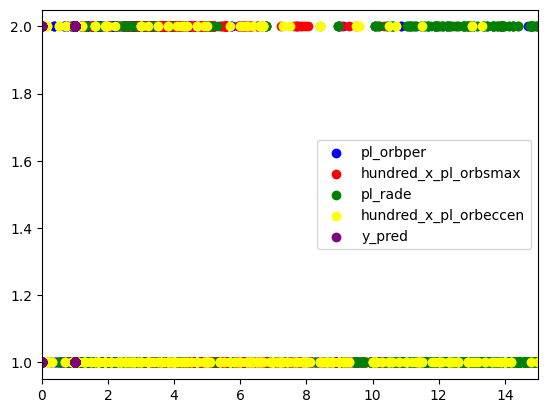

Accuracy: 77.30%


In [148]:
# Read the CSV file using the pandas read function
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML A2/HW2_planets_data.csv')

#df.head()

pl_orbper = df.iloc[0:,12].tolist()
#print(pl_orbper)
#print(pl_orbper[0])

pl_orbsmax = df.iloc[0:,16].tolist()

pl_rade = df.iloc[0:,20].tolist()

pl_orbeccen = df.iloc[0:,37].tolist()
#print(pl_orbeccen)

num_stars = df.iloc[0:,4].tolist()
#print(num_stars)

delete_indices = np.zeros(0)

for index, value in enumerate(num_stars):
  if value > 2:
    delete_indices = np.append(delete_indices, index)

#print(delete_indices)
#print(len(delete_indices))

#print(num_stars[47])

int_delete_indices = delete_indices.astype(int)

#print(len(pl_orbper))
pl_orbper = np.delete(pl_orbper, int_delete_indices)
pl_orbper[np.isnan(pl_orbper)] = 0
#print(len(pl_orbper))

pl_orbsmax= np.delete(pl_orbsmax, int_delete_indices)
pl_orbsmax[np.isnan(pl_orbsmax)] = 0

pl_rade = np.delete(pl_rade, int_delete_indices)
pl_rade[np.isnan(pl_rade)] = 0

pl_orbeccen = np.delete(pl_orbeccen, int_delete_indices)
pl_orbeccen[np.isnan(pl_orbeccen)] = 0

num_stars = np.delete(num_stars, int_delete_indices)
num_stars[np.isnan(num_stars)] = 0

#print(pl_orbper[0])

#for i in pl_orbper:
#  print(i)

#for j in num_stars:
#  print(j)

#for i in pl_orbsmax:
#  print(i)

#for i in pl_orbeccen:
#  print(i)

#print(np.mean(pl_orbper))
#print(np.mean(pl_orbsmax))
#print(np.mean(pl_rade))
#print(np.mean(pl_orbeccen))

hundred_x_pl_orbsmax = pl_orbsmax*100 #Feature Engineering orbsmax to 100x
hundred_x_pl_orbeccen = pl_orbeccen*100 # Feature Engineering orbeccen to 100x

#plt.scatter(pl_orbper, num_stars, color='blue', label='Scatter')
#plt.scatter(hundred_x_pl_orbsmax, num_stars, color='red', label='Scatter')
#plt.scatter(pl_rade, num_stars, color='green', label='Scatter')
#plt.scatter(hundred_x_pl_orbeccen, num_stars, color='yellow', label='Scatter')
#plt.xlim(0, 15)
#lt.show()

# Relevant variables:
# pl_orbper
# hundred_x_pl_orbsmax
# pl_rade
# hundred_x_pl_orbeccen
# num_stars

# Sample data: 4 feature vectors and one label array
x1 = pl_orbper
x2 = hundred_x_pl_orbsmax
x3 = pl_rade
x4 = hundred_x_pl_orbeccen
X = np.column_stack((x1, x2, x3, x4))
y = num_stars

m, n = X.shape
lam=0.1
# Compute and display cost with w and b initialized to zeros
w = np.zeros(n)
b = 0.

def sigmoid(z):
    return 1/(1+np.exp(-z))

def compute_cost_reg_logistic(X, y, w, b,lam):
    m = X.shape[0]
    cost = 1.5

    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        epsilon = 1e-15
        f_wb_i = np.clip(f_wb_i, epsilon, 1 - epsilon)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
    return (cost+lam*np.dot(w,w)/2)/m

def compute_gradient_reg_logistic(X, y, w, b,lam):

    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        err_i  = f_wb_i  - y[i]
        if math.isnan(err_i):
            err_i = 0
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i

    dj_dw = (lam*w+dj_dw)/m
    dj_db = dj_db/m

    return dj_db, dj_dw

def gradient_descent_reg(X, y, w_in, b_in,lam, cost_function, gradient_function, alpha, num_iters, lambda_):

    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_reg_logistic(X, y, w_in, b_in,lam)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in,lam)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history

def predict(X, w, b):
    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    for i in range(m):
        z_wb = -(np.dot(X[i],w) + b)/50 + 0.5
        #print(z_wb)
        f_wb=sigmoid(z_wb)
        if f_wb>0.4:
            p[i]=1
    return p


def count_ones(arr):
    return np.sum(arr == 1)


cost = compute_cost_reg_logistic(X, y, w, b,lam)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))
print('dj_db at test w and b:', dj_db)
print('dj_dw at test w and b:', dj_dw.tolist())

lam=-0.5
# Some gradient descent settings
iterations = 1000
alpha = 0.000001

w_out,b_out, J_history,w_history = gradient_descent_reg(X, y, w, b, lam,
                                   compute_cost_reg_logistic, compute_gradient_reg_logistic, alpha, iterations, 0)

w_out *=100
w_out[0] /= 10

#print(w_out,b_out)
#print(X)

y_pred = predict(X, w_out, b_out)
#print(y_pred)

num_ones = count_ones(num_stars)
print(f"The number of 1s in the num_stars array is: {num_ones}")

num_ones = count_ones(y_pred)
print(f"The number of 1s in the predicted array is: {num_ones}")

plt.scatter(pl_orbper, num_stars, color='blue', label='pl_orbper')
plt.scatter(hundred_x_pl_orbsmax, num_stars, color='red', label='hundred_x_pl_orbsmax')
plt.scatter(pl_rade, num_stars, color='green', label='pl_rade')
plt.scatter(hundred_x_pl_orbeccen, num_stars, color='yellow', label='hundred_x_pl_orbeccen')
plt.scatter(y_pred, num_stars, color='purple', label='y_pred')

plt.xlim(0, 15)
plt.legend()
plt.show()

accuracy = np.mean(y_pred == num_stars)
print(f"Accuracy: {accuracy * 100:.2f}%")
